<a href="https://colab.research.google.com/github/VinayBhushan56/Twitter_Sentiment_Analysis/blob/main/Twitter_Sentiment_Analysis_Classification_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color ='pickle'>**Notebook Overview**
We will create 3 pipelines:

    1. Data Preprocessing + Sparse Embeddings (TF-IDF) + ML Model pipeline

    2. Feature Engineering + ML Model pipeline

    3. Feature Engineering + Data Preprocessing + Sparse Embeddings(TF-IDF) + ML Model pipeline.

In [1]:
# Import necessary libraries
import pandas as pd
from pathlib import Path

# Import the joblib library for saving and loading models
import joblib

# Import scikit-learn classes for building models
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import TransformerMixin, BaseEstimator

# Import the scipy library for working with sparse matrices
from scipy.sparse import csr_matrix

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  drive.mount('/content/drive')

  !pip install -U nltk -qq
  !pip install -U spacy -qq
  !python -m spacy download en_core_web_sm -qq

  basepath  = '/content/drive/MyDrive/data'
  sys.path.append('/content/drive/MyDrive/data/custom-functions')
else:
  basepath = '/home/vinay/Insync/google_drive_shaannoor/data'
  sys.path.append('/home/vinay/Insync/google_drive_shaannoor/data/custom-functions')

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 55.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
en-core-web-sm 3.5.0 requires spacy<3.6.0,>=3.5.0, but you have spacy 3.6.0 which is incompatible.
2023-07-18 16:32:06.875710: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-18 16:32:07.907750: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-07-18 16:32:09.322780: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at l

In [4]:
sys.path

['/content',
 '/env/python',
 '/usr/lib/python310.zip',
 '/usr/lib/python3.10',
 '/usr/lib/python3.10/lib-dynload',
 '',
 '/usr/local/lib/python3.10/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.10/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/content/drive/MyDrive/data/custom-functions']

In [5]:
base_folder = Path(basepath)
data_folder = base_folder/'datasets/Coke_Pepsi_tweets'
model_folder = base_folder/'models/Twitter_Sentiment_Analysis'
custom_functions = base_folder/'custom-functions'

In [6]:
import custom_preprocessor_mod as cp
from  featurizer import ManualFeatures
from  plot_learning_curve import plot_learning_curve

# <font color ='pickle'>**Load dataset**

In [7]:
file = data_folder/ 'new_tweets_sentiment.xlsx'

In [8]:
file

PosixPath('/content/drive/MyDrive/data/datasets/Coke_Pepsi_tweets/new_tweets_sentiment.xlsx')

In [9]:
data = pd.read_excel(file,index_col =1)

In [10]:
data.head()

,Unnamed: 0,cleaned_tweets,Year,Month,Day,City,Country,brand,sentiment
id,,,,,,,,,
1,0,sheetz super cool change new machine cocacola,2023,6,26,Greensburg,US,coke,Positive
2,1,need cocacola caffeine free version oz mini si...,2023,6,26,San Diego,US,coke,Positive
3,2,food vice cocacola oz mini time week tho ll fo...,2023,6,26,San Diego,US,coke,Positive
4,3,cocacola official taste summer takeataste,2023,6,26,Astoria,US,coke,Neutral
5,4,pringle c breakfast club d cocacola,2023,6,25,Mandeville,US,coke,Neutral


In [11]:
sel_data = data[['cleaned_tweets', 'sentiment']]

In [12]:
sel_data.head()

,cleaned_tweets,sentiment
id,,
1,sheetz super cool change new machine cocacola,Positive
2,need cocacola caffeine free version oz mini si...,Positive
3,food vice cocacola oz mini time week tho ll fo...,Positive
4,cocacola official taste summer takeataste,Neutral
5,pringle c breakfast club d cocacola,Neutral


In [13]:
label_mapping = {'Positive': 1, 'Neutral': 0, 'Negative': -1}  # Define the mapping from original labels to updated labels
sel_data['labels'] = sel_data['sentiment'].replace(label_mapping)

<ipython-input-13-64bc6503c9d0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sel_data['labels'] = sel_data['sentiment'].replace(label_mapping)


In [14]:
sel_data.head()

,cleaned_tweets,sentiment,labels
id,,,
1,sheetz super cool change new machine cocacola,Positive,1
2,need cocacola caffeine free version oz mini si...,Positive,1
3,food vice cocacola oz mini time week tho ll fo...,Positive,1
4,cocacola official taste summer takeataste,Neutral,0
5,pringle c breakfast club d cocacola,Neutral,0


In [15]:
sel_data['labels'].value_counts()

 1    4889
 0    3209
-1    1902
Name: labels, dtype: int64

In [16]:
X=sel_data[['cleaned_tweets']]
y=sel_data[['labels']]

# <font color ='pickle'>**Train-Test Split of Data**

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,stratify=y, random_state=42)

In [39]:
X_test.dtypes

cleaned_tweets    object
dtype: object

In [19]:
y_train.value_counts()

labels
 1        3667
 0        2407
-1        1426
dtype: int64

In [20]:
y_test.value_counts()

labels
 1        1222
 0         802
-1         476
dtype: int64

As we can see our data is well balannced.

## <font color ='pickle'>**Pipeline 1: Data Preprocessing + Sparse Embeddings (TF-IDF) + ML Model**

### <font color ='pickle'>**Create Pipeline**

In [21]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

In [22]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),  # Text feature extraction
    ('classifier', None)  # Classifier placeholder
])

### <font color ='pickle'>**Parameter Grid**

In [23]:
param_grid_classifier = [
    {
        'tfidf__max_features': [100, 500, 1000],
        'classifier': [KNeighborsClassifier()],
        'classifier__n_neighbors': [3, 5, 7]
    },
    {
        'tfidf__max_features': [100, 500, 1000],
        'classifier': [SVC()],
        'classifier__C': [0.1, 1, 10, 100, 1000],
        'classifier__kernel': ['linear', 'rbf']
    },
    {
        'tfidf__max_features': [100, 500, 1000],
        'classifier': [MultinomialNB()],
        'classifier__alpha': [0.1, 1, 10]
    }
]


### <font color ='pickle'>**Specify GridSearch**

In [24]:
# We are using Gridserach to find fine tune hyperparameters using cross validation
# The advantage of using pipelines is that we can avoid data leakage
# Since we have balanced data set, we will use default scoring method of accuracy
# the typical value of cv used is 5.

grid_classifier_1 = GridSearchCV(pipeline, param_grid_classifier, scoring='f1_macro', cv=5)

### <font color ='pickle'>**Fit the model**

In [71]:
y_train_arr.ravel().shape

(7500,)

In [25]:
y_train = y_train.values.ravel()

In [26]:
X_train = X_train.squeeze().tolist()

In [27]:
grid_classifier_1.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('classifier', None)]),
             param_grid=[{'classifier': [KNeighborsClassifier()],
                          'classifier__n_neighbors': [3, 5, 7],
                          'tfidf__max_features': [100, 500, 1000]},
                         {'classifier': [SVC(C=1, kernel='linear')],
                          'classifier__C': [0.1, 1, 10, 100, 1000],
                          'classifier__kernel': ['linear', 'rbf'],
                          'tfidf__max_features': [100, 500, 1000]},
                         {'classifier': [MultinomialNB()],
                          'classifier__alpha': [0.1, 1, 10],
                          'tfidf__max_features': [100, 500, 1000]}],
             scoring='f1_macro')

In [79]:
y_train.shape

(7500,)

In [43]:
import numpy as np

#X_train = np.array(X_train).reshape(-1, 1)


In [29]:
print(f'Best cross-validation score: {grid_classifier_1.best_score_:.2f}')
print("\nBest parameters: ", grid_classifier_1.best_params_)
print("\nBest estimator: ", grid_classifier_1.best_estimator_)

Best cross-validation score: 0.79

Best parameters:  {'classifier': SVC(C=1, kernel='linear'), 'classifier__C': 1, 'classifier__kernel': 'linear', 'tfidf__max_features': 1000}

Best estimator:  Pipeline(steps=[('tfidf', TfidfVectorizer(max_features=1000)),
                ('classifier', SVC(C=1, kernel='linear'))])


### <font color ='pickle'>**Save Model**

In [30]:
file_best_estimator_pipeline1_tweets_1 = model_folder / 'pipeline1_tweets1_best_estimator.pkl'
file_complete_grid_pipeline1_tweets_1 = model_folder / 'pipeline1_tweets1_complete_grid.pkl'

In [31]:
joblib.dump(grid_classifier_1.best_estimator_, file_best_estimator_pipeline1_tweets_1)
joblib.dump(grid_classifier_1, file_complete_grid_pipeline1_tweets_1)

['/content/drive/MyDrive/data/models/Twitter_Sentiment_Analysis/pipeline1_tweets1_complete_grid.pkl']

### <font color ='pickle'>**Load Saved Model**

In [32]:
# load the saved model
best_estimator_pipeline1_tweets1 = joblib.load(file_best_estimator_pipeline1_tweets_1)
complete_grid_pipeline1_tweets1 = joblib.load(file_complete_grid_pipeline1_tweets_1)

### <font color ='pickle'>**Plot Learning Curve**

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

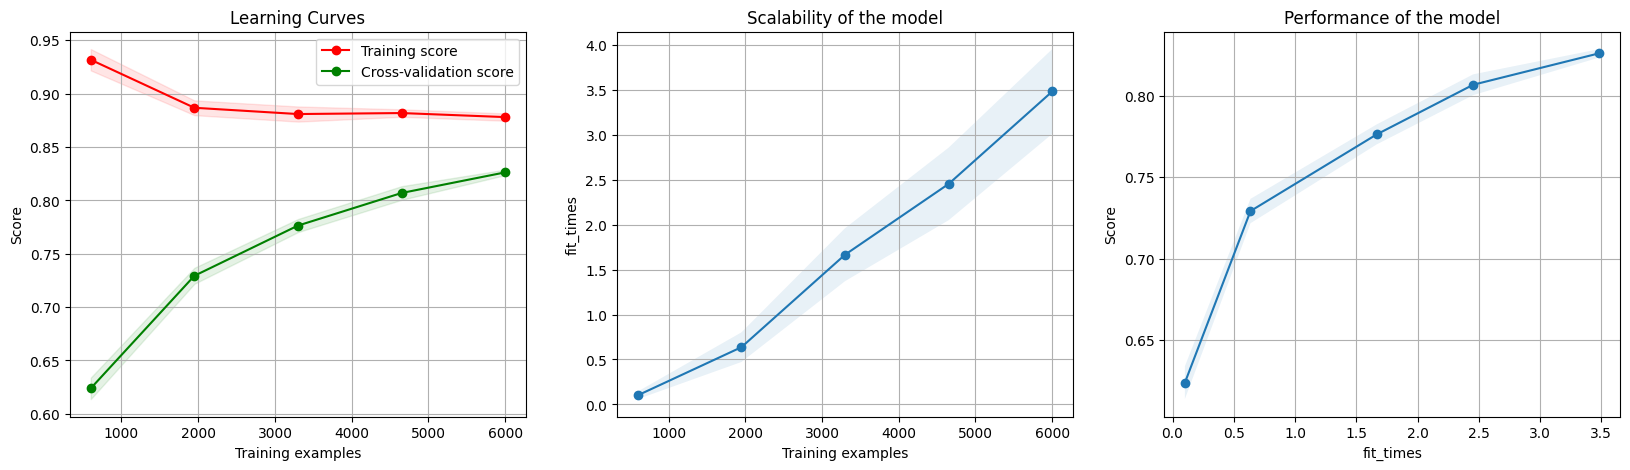

In [33]:
# plot learning curces
plot_learning_curve(best_estimator_pipeline1_tweets1, 'Learning Curves',
                    X_train, y_train, n_jobs=-1)

### <font color = 'pickle'>**Check Cross Validation Score and Train Score**

In [34]:
# let's check the train scores
print(best_estimator_pipeline1_tweets1.score(X_train, y_train))

# let's check the cross validation score
print(complete_grid_pipeline1_tweets1.best_score_)

0.8744
0.79416761530417


In [ ]:
# Final Pipeline
def final_pipeline(text):
    # X_test_cleaned = cp.SpacyPreprocessor(model='en_core_web_sm').transform(text)
    cleaned_text = joblib.load(file_X_test_cleaned_sparse_embed)
    best_estimator_pipeline1_round1 = joblib.load(file_best_estimator_pipeline1_round1)
    predictions = best_estimator_pipeline1_round1.predict(cleaned_text)
    return predictions

### <font color ='pickle'>**Classification report for test dataset**

In [44]:
X_test = np.array(X_test).reshape(-1, 1)

In [46]:
X_test = X_test.squeeze().tolist()

In [47]:
y_test_pred = best_estimator_pipeline1_tweets1.predict(X_test)

In [37]:
#y_test_pred = y_test_pred.reshape(-1)

In [48]:
y_test_pred

array([ 0,  0, -1, ...,  0, -1,  0])

* As we have already seen, our dataset is well balanced. Hence we have used accuracy as our scoring method.
* However, it is a good idea to also look at classification report which gives precision, recall, and f1-score for both labels and average score also.

In [49]:
print('\nTest set classification report:\n\n',
      classification_report(y_test, y_test_pred))


Test set classification report:

               precision    recall  f1-score   support

          -1       0.85      0.57      0.68       476
           0       0.74      0.97      0.84       802
           1       0.91      0.85      0.88      1222

    accuracy                           0.83      2500
   macro avg       0.83      0.79      0.80      2500
weighted avg       0.84      0.83      0.83      2500



In [39]:
y_test.shape

(2500, 1)

In [40]:
y_test_pred.shape

(1,)